<a href="https://colab.research.google.com/github/KANG-HYUNIL/Kaggle_Competition/blob/main/Kaggle_HousingPrices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# kaggle api key upload
from google.colab import files

files.upload()



Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kangcon","key":"faeeace71de94729afc1e45aa2dc359f"}'}

In [ ]:
#directory for Kaggle
!ls -lha kaggle.json
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!pwd
!chmod 600 ~/.kaggle/kaggle.json


-rw-r--r-- 1 root root 63 Sep 11 10:28 kaggle.json
/content


In [ ]:
#Download Housing Prices DataSet
!kaggle competitions download -c home-data-for-ml-course

  0% 0.00/386k [00:00<?, ?B/s]
100% 386k/386k [00:00<00:00, 403MB/s]


In [ ]:
!unzip home-data-for-ml-course.zip

Archive:  home-data-for-ml-course.zip
  inflating: data_description.txt    
  inflating: sample_submission.csv   
  inflating: sample_submission.csv.gz  
  inflating: test.csv                
  inflating: test.csv.gz             
  inflating: train.csv               
  inflating: train.csv.gz            


In [ ]:
# dependency import, analysis data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier

!pip install -q scikit-optimize
from skopt import gp_minimize
from skopt.space import Real, Categorical, Integer
from skopt.utils import use_named_args

#check table
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")
df_train.head()
df_test.head()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 4.6 MB/s eta 0:00:00


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


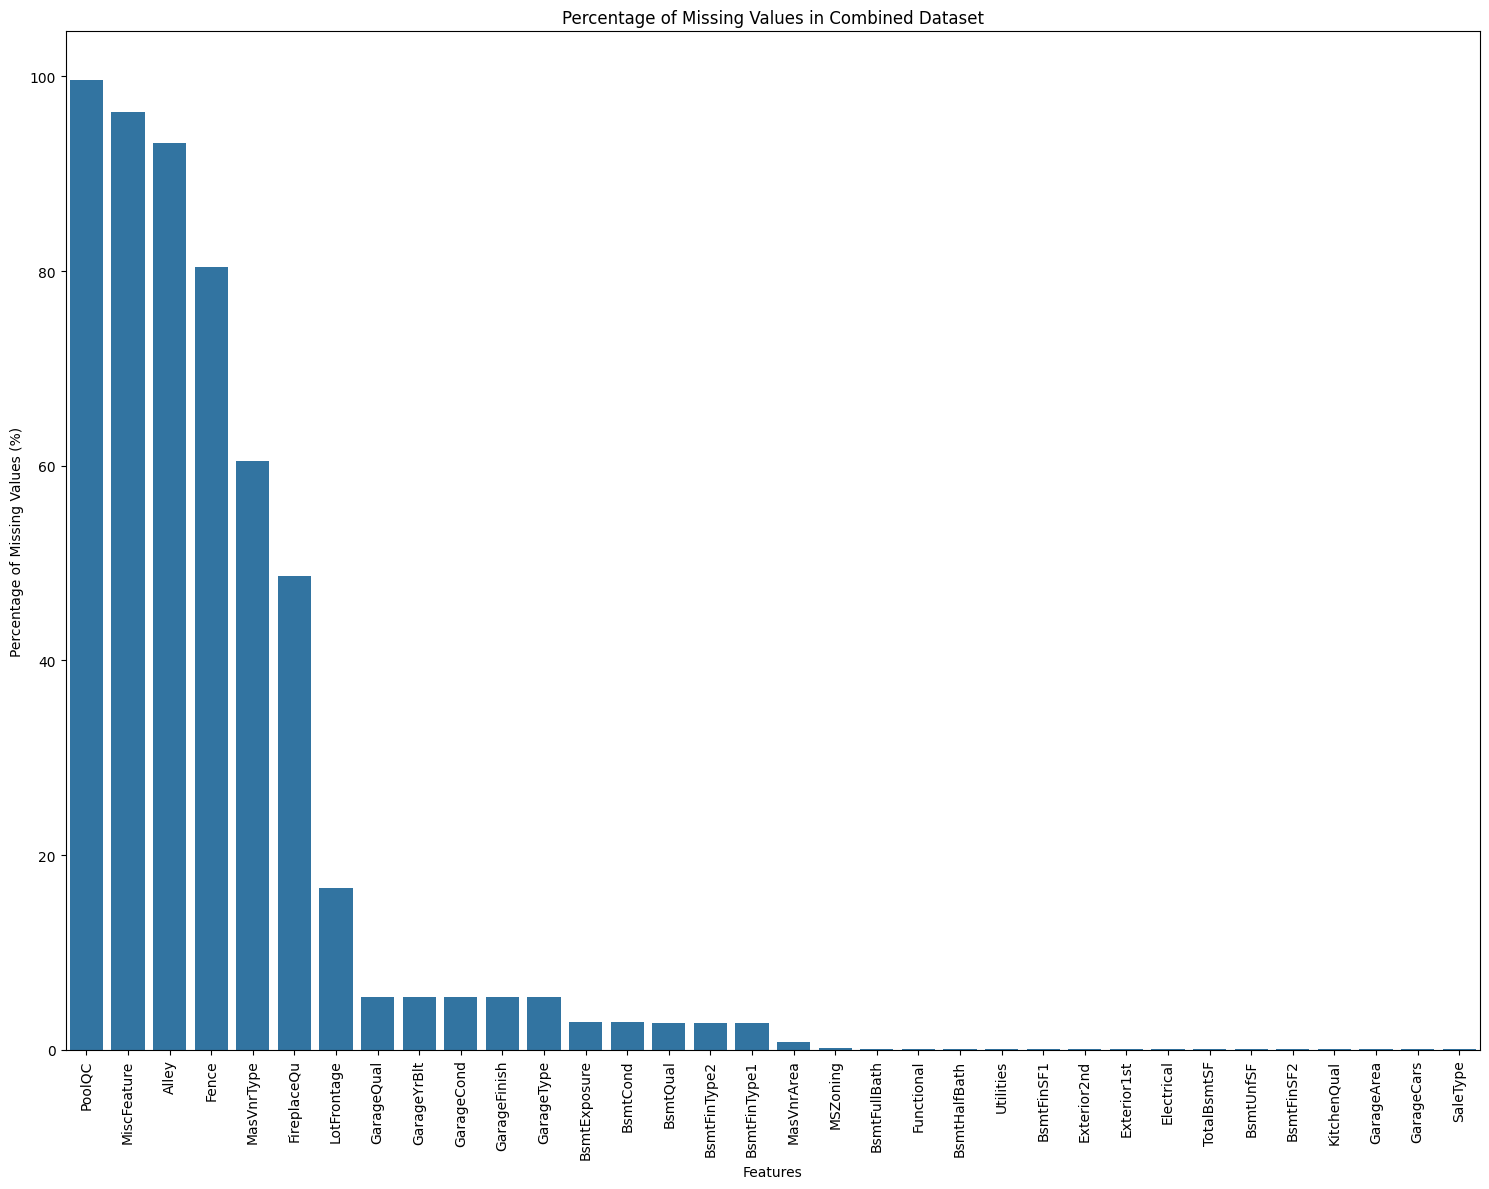

In [ ]:
# -- 특성 중 결측치가 있는 특성들에 대해 결측치 비율 가시화 --

# Combine train and test data for easier missing value analysis
combined_df = pd.concat([df_train.drop('SalePrice', axis=1), df_test], ignore_index=True)

# Check for missing values in the combined data
missing_values_combined = combined_df.isnull().sum()
columns_with_missing_combined = missing_values_combined[missing_values_combined > 0]

# Calculate missing value percentages for the combined data
missing_percentage_combined = (combined_df.isnull().sum() / len(combined_df)) * 100

# Filter out features with no missing values and sort in descending order
missing_percentage_combined = missing_percentage_combined[missing_percentage_combined > 0].sort_values(ascending=False)

# Create a bar plot of missing value percentages
plt.figure(figsize=(15, 12))
sns.barplot(x=missing_percentage_combined.index, y=missing_percentage_combined.values)
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Percentage of Missing Values (%)')
plt.title('Percentage of Missing Values in Combined Dataset')
plt.tight_layout()
plt.show()

In [ ]:


def analyze_feature_vs_saleprice(df, feature):
    """
    특정 특성과 SalePrice 간의 관계를 시각화하고 특성의 기술 통계량을 표시합니다.

    Args:
        df (pd.DataFrame): 분석할 데이터프레임 (df_train 사용).
        feature (str): 분석할 특성의 이름.
    """
    print(f"--- 특성 '{feature}' 분석 ---")

    # 특성 데이터 타입 확인
    if df[feature].dtype in ['int64', 'float64']:
        # 수치형 특성인 경우
        # print(f"\n수치형 특성: {feature}")
        # print("\n기술 통계량:")
        # display(df[feature].describe())

        plt.figure(figsize=(8, 6))
        sns.scatterplot(x=df[feature], y=df['SalePrice'])
        plt.title(f'{feature} vs SalePrice')
        plt.xlabel(feature)
        plt.ylabel('SalePrice')
        plt.show()

        # # 분포 시각화 (히스토그램 및 KDE)
        # plt.figure(figsize=(8, 6))
        # sns.histplot(df[feature].dropna(), kde=True)
        # plt.title(f'{feature} 분포')
        # plt.xlabel(feature)
        # plt.ylabel('빈도')
        # plt.show()

    elif df[feature].dtype == 'object':
        # 범주형 특성인 경우
        # print(f"\n범주형 특성: {feature}")
        # print("\n범주별 개수:")
        # display(df[feature].value_counts())

        plt.figure(figsize=(10, 6))
        sns.boxplot(x=df[feature], y=df['SalePrice'], data=df)
        plt.title(f'{feature} vs SalePrice')
        plt.xlabel(feature)
        plt.ylabel('SalePrice')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

    else:
        print(f"\n지원하지 않는 데이터 타입: {df[feature].dtype} - 특성 '{feature}'")

    print("-" * (len(feature) + 15)) # 구분선 출력

--- 특성 'Street' 분석 ---


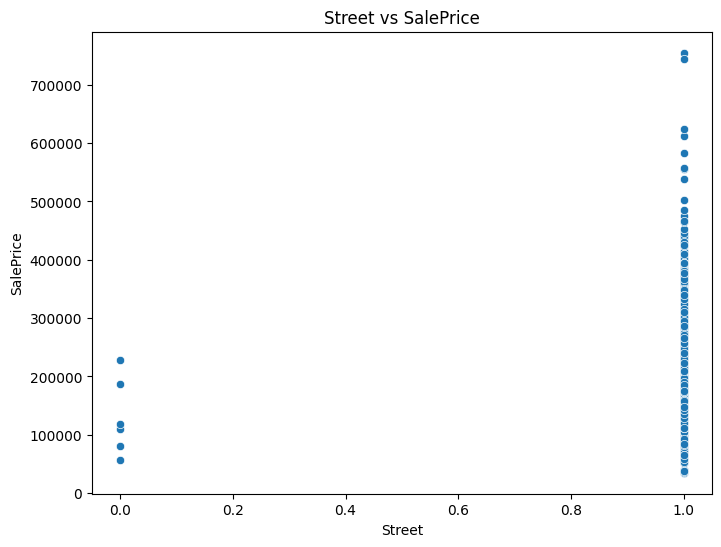

---------------------


In [ ]:
# 사용 예시: OverallQual 특성에 대해 함수 실행
analyze_feature_vs_saleprice(df_train, 'Street')

# 다른 특성에 대해서도 실행해 보세요 (예: GrLivArea, GarageCars 등)
# analyze_feature_vs_saleprice(df_train, 'GrLivArea')
# analyze_feature_vs_saleprice(df_train, 'MSZoning') # 범주형 특성 예시

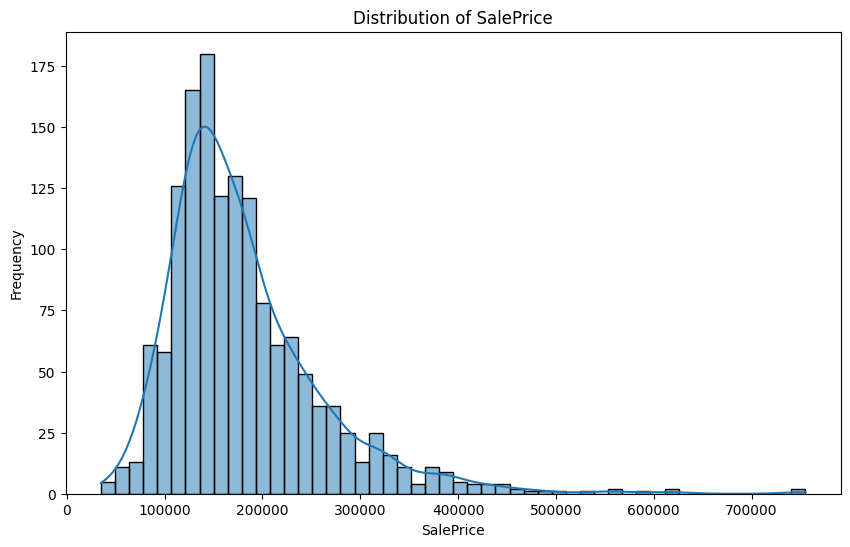

In [ ]:
# Visualize the distribution of SalePrice
plt.figure(figsize=(10, 6))
sns.histplot(df_train['SalePrice'], kde=True, bins=50)
plt.title('Distribution of SalePrice')
plt.xlabel('SalePrice')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# -- 특정 특성의 분포 시각화

def analyze_combined_feature_distribution(df_combined, feature):
    """
    통합 데이터셋(train + test)에서 특정 특성의 분포를 시각화합니다.

    Args:
        df_combined (pd.DataFrame): train과 test를 합친 데이터프레임.
        feature (str): 분석할 특성의 이름.
    """
    print(f"--- 통합 데이터셋에서 특성 '{feature}' 분포 분석 ---")

    # 특성 데이터 타입 확인
    if df_combined[feature].dtype in ['int64', 'float64']:
        # 수치형 특성인 경우
        df_combined[feature].describe() # 기술 통계량
        plt.hist(df_combined[feature], bins = 30)
        plt.title(f'{feature} 분포')
        plt.xlabel(feature)
        plt.ylabel('빈도')
        plt.show()

        pass


    elif df_combined[feature].dtype == 'object':
        # 범주형 특성인 경우
        df_combined[feature].value_counts()

        sns.countplot(x=df_combined[feature], data=df_combined)
        plt.title(f'{feature} 분포')
        plt.xlabel(feature)
        plt.ylabel('빈도')
        plt.show()


        pass

    else:
        print(f"\n지원하지 않는 데이터 타입: {df_combined[feature].dtype} - 특성 '{feature}'")

    print("-" * (len(feature) + 30)) # 구분선 출력

# -- PoolQC에 대한 분석
analyze_combined_feature_distribution(pd.concat([df_train, df_test], ignore_index=True), 'SaleType')

NameError: name 'pd' is not defined

In [ ]:
#-- 결측치 존재 특성의 결측치 처리 코드


def df_fillna(combined_df):


  # PoolQC에서 결측치는 Pool이 없음을 의미한다. 최빈이나 평균이 아니라 None으로 하자.
  combined_df['PoolQC'] = combined_df['PoolQC'].fillna("None")

  #MiscFeature 에서 결측치는 아무런 추가 시설(Feature)이 없음을 의미. 최빈이나 평균 대신 None으로 대체한다

  combined_df['MiscFeature'] = combined_df['MiscFeature'].fillna("None")

  #Alley에서 결측치는 골목 접근로가 없다는 것을 의미. 최빈이나 평균 대신 None으로 대체
  combined_df['Alley'] = combined_df['Alley'].fillna("None")


  #Fence에서 결측치는 Fence가 없다는 것을 의미. None으로 처리
  combined_df['Fence'] = combined_df['Fence'].fillna("None")

  #MasVnrType의 결측치는 Venner이 없다는 것을 의미, None으로 처리
  combined_df['MasVnrType'] = combined_df['MasVnrType'].fillna("None")

  #FireplaceQu의 결측치는 Fireplace 가 없다는 것을 의미, None으로 처리
  combined_df['FireplaceQu'] = combined_df['FireplaceQu'].fillna("None")

  #LotFrontage 는 주택과 연결된 거리의 Feet 크기. 무작정 평균치나 0으로 처리하기는 위험할거다.
  # Discussion의 조언으로, 이웃 즉 Neighborhood 의 주택들의 평균치로 처리해보기로 함
  combined_df["LotFrontage"] = combined_df.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

  #Garage 관련 특성들은 결측치 시 모두 Garage 가 없음을 의미한다. 전부 None으로 처리하자.
  combined_df["GarageType"] = combined_df["GarageType"].fillna("None")
  combined_df["GarageFinish"] = combined_df["GarageFinish"].fillna("None")
  combined_df["GarageQual"] = combined_df["GarageQual"].fillna("None")
  combined_df["GarageCond"] = combined_df["GarageCond"].fillna("None")

  combined_df['GarageYrBlt'] = combined_df['GarageYrBlt'].fillna(0)
  combined_df['GarageCars'] = combined_df['GarageCars'].fillna(0)
  combined_df['GarageArea'] = combined_df['GarageArea'].fillna(0)


  #Bsmt(Basement) 관련 특성들은 결측치 시 모두 Basement가 없음을 의미할거다. None 및 0 처리.
  combined_df['BsmtQual'] = combined_df['BsmtQual'].fillna("None")
  combined_df['BsmtCond'] = combined_df['BsmtCond'].fillna("None")
  combined_df['BsmtExposure'] = combined_df['BsmtExposure'].fillna("None")
  combined_df['BsmtFinType1'] = combined_df['BsmtFinType1'].fillna("None")
  combined_df['BsmtFinType2'] = combined_df['BsmtFinType2'].fillna("None")

  combined_df['BsmtFinSF1'] = combined_df['BsmtFinSF1'].fillna(0)
  combined_df['BsmtFinSF2'] = combined_df['BsmtFinSF2'].fillna(0)
  combined_df['BsmtUnfSF'] = combined_df['BsmtUnfSF'].fillna(0)
  combined_df['TotalBsmtSF'] = combined_df['TotalBsmtSF'].fillna(0)



  #MasVnrArea 관련 특성들 결측치는, 그 veneer이 없다고 판단, None과 0 처리
  combined_df['MasVnrArea'] = combined_df['MasVnrArea'].fillna(0)
  combined_df['MasVnrType'] = combined_df['MasVnrType'].fillna("None")


  #MSZoning은 결측치에 대한 설명이 없다. 반드시 있어야 하는 값이라는 건데, 결측치의 비율이 매우 낮다.
  #따라서 최빈값인 RL로 대체해보자
  combined_df['MSZoning'] = combined_df['MSZoning'].fillna(combined_df['MSZoning'].mode()[0])


  #BsmtFullBath 는 결측치에 대한 설명이 없고 수치형이다. 0이 가장 많기도 하고, 결측치인 경우 없다는 것ㅇ로 해석할 수 있을듯.
  # 0으로 처리하자
  combined_df['BsmtFullBath'] = combined_df['BsmtFullBath'].fillna(0)
  combined_df['BsmtHalfBath'] = combined_df['BsmtHalfBath'].fillna(0)


  #Functional는 NA에 대한 설명이 없으나, 결측치 비율이 매우 낮고, 대부분 Typ를 값으로 가짐. Typ로 대체
  combined_df['Functional'] = combined_df['Functional'].fillna(combined_df['Functional'].mode()[0])


  #Utilities는 결측치 비율도 매우 낮고, 거의 모든 데이터가 동일한 값인 AllPub를 가진다.
  #속성 수를 줄이기 위해, 이런 의미나 변별이 없는 속성은 제거해보자
  try :
    combined_df = combined_df.drop(['Utilities'], axis=1)
  except:
    pass


  # Exterior1st, Exterior2nd 속성은 모두 범주형. NA 설명 없음. 결측치 비율 매우 낮으며 분포가 한 쪽이 몰려잇는게 강함.
  # 따라서 최빈값으로 결측치 처리
  combined_df['Exterior1st'] = combined_df['Exterior1st'].fillna(combined_df['Exterior1st'].mode()[0])
  combined_df['Exterior2nd'] = combined_df['Exterior2nd'].fillna(combined_df['Exterior2nd'].mode()[0])


  #Electrical 는 범주형, NA 설명 없음, 결측치 비율 매우 낮음, 분포 쏠림 현상.
  # 최빈값으로 결측치 처리
  combined_df['Electrical'] = combined_df['Electrical'].fillna(combined_df['Electrical'].mode()[0])



  #KitchenQual 는 범주형, NA 설명 없음,결측치 비율 매우 낮음, 분포가 Ta/Gd로 쏠림 현상.
  # 그러나 Ta가 좀 더 많고, 중간 값을 의미하기에 Ta로 처리
  combined_df['KitchenQual'] = combined_df['KitchenQual'].fillna(combined_df['KitchenQual'].mode()[0])


  #SaleType 는 범주형,' NA 설명 없음, 결측치 비율 매우 낮음, 분포가 한 쪽으로 쏠림
  #최빈값 처리
  combined_df['SaleType'] = combined_df['SaleType'].fillna(combined_df['SaleType'].mode()[0])


  return combined_df



combined_df = df_fillna(combined_df=combined_df)
df_train = df_fillna(combined_df=df_train)
df_test = df_fillna(combined_df=df_test)

In [ ]:
# 결측치 처리 후에도 존재하는지 재검증하는 메서드
def check_missing_values(df):
    missing_values = df.isnull().sum()
    columns_with_missing = missing_values[missing_values > 0]
    return columns_with_missing


print(check_missing_values(df_train))
print(check_missing_values(df_test))

Series([], dtype: int64)
Series([], dtype: int64)


In [ ]:
# 범주형 특성들에 대해 Label Encoding 처리하는 메서드
from sklearn.preprocessing import LabelEncoder

# df_combined, df_train, df_test를 인자로 받아 일관된 Label Encoding 수행 후 반환
def label_encoding_consistent(df_combined: pd.DataFrame, df_train: pd.DataFrame, df_test: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    전체 데이터셋(combined_df)을 기준으로 Label Encoder를 학습시키고,
    이를 사용하여 combined_df, df_train, df_test 각각에 Label Encoding을 적용합니다.

    Args:
        df_combined (pd.DataFrame): 학습/테스트가 합쳐진 원본 데이터프레임.
        df_train (pd.DataFrame): 학습 데이터프레임.
        df_test (pd.DataFrame): 테스트 데이터프레임.

    Returns:
        tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]: Label Encoding이 적용된
        (df_combined_encoded, df_train_encoded, df_test_encoded) 튜플.
    """
    # 데이터프레임 복사하여 원본 유지
    df_combined_encoded = df_combined.copy()
    df_train_encoded = df_train.copy()
    df_test_encoded = df_test.copy()

    # object 타입 특성 목록 가져오기 (combined_df 기준으로)
    object_cols = df_combined_encoded.select_dtypes(include=['object']).columns.tolist()

    # 각 object 타입 특성에 대해 Label Encoding 적용
    for col in object_cols:
        # 전체 데이터셋에서 범주 학습 (fit)
        lb = LabelEncoder()
        lb.fit(df_combined_encoded[col].astype(str)) # 결측치 등을 str로 변환하여 처리 가능하게 함

        # 학습된 Encoder를 사용하여 각 데이터셋에 적용 (transform)
        df_combined_encoded[col] = lb.transform(df_combined_encoded[col].astype(str))
        df_train_encoded[col] = lb.transform(df_train_encoded[col].astype(str))
        df_test_encoded[col] = lb.transform(df_test_encoded[col].astype(str))

    return df_combined_encoded, df_train_encoded, df_test_encoded

# 수정된 함수 적용 (기존 변수명 사용)
combined_df_labeled, df_train_labeled, df_test_labeled = label_encoding_consistent(df_combined=combined_df, df_train=df_train, df_test=df_test)

print("Label Encoding 일관되게 적용 완료.")
# 확인 (필요시 주석 해제)
# display(combined_df_labeled.head())
# display(df_train_labeled.head())
# display(df_test_labeled.head())

Label Encoding 일관되게 적용 완료.


In [ ]:
# 범주형 특성들에 대해 One-Hot Encoding 하는 메서드

# df_combined, df_train, df_test를 인자로 받아 일관된 One-Hot Encoding 수행 후 반환
def one_hot_encoding_consistent(df_combined: pd.DataFrame, df_train: pd.DataFrame, df_test: pd.DataFrame, target_col: str = "SalePrice") -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    combined_df, df_train, df_test를 합쳐서 One-Hot Encoding을 수행하고,
    다시 원래 길이대로 분리하여 일관된 컬럼 구조를 가진 데이터프레임을 반환합니다.

    Args:
        df_combined (pd.DataFrame): 학습/테스트가 합쳐진 원본 데이터프레임.
        df_train (pd.DataFrame): 학습 데이터프레임.
        df_test (pd.DataFrame): 테스트 데이터프레임.
        target_col (str, optional): Target 변수 컬럼 이름. None이 아니면 Encoding 대상에서 제외합니다.

    Returns:
        tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]: One-Hot Encoding이 적용된
        (df_combined_encoded, df_train_encoded, df_test_encoded) 튜플.
    """
    # 데이터프레임 복사하여 원본 유지
    df_combined_copy = df_combined.copy()
    df_train_copy = df_train.copy()
    df_test_copy = df_test.copy()

    # Target 컬럼 임시 분리 (Encoding 대상에서 제외)
    if target_col and target_col in df_train_copy.columns:
        train_target = df_train_copy[target_col]
        df_train_copy = df_train_copy.drop(target_col, axis=1)
    else:
        train_target = None # 학습 데이터에 Target 컬럼이 없는 경우

    # Id 컬럼 임시 분리 (Encoding 대상에서 제외)
    train_ids = df_train_copy['Id'] if 'Id' in df_train_copy.columns else None
    test_ids = df_test_copy['Id'] if 'Id' in df_test_copy.columns else None

    if 'Id' in df_train_copy.columns:
        df_train_copy = df_train_copy.drop('Id', axis=1)
    if 'Id' in df_test_copy.columns:
        df_test_copy = df_test_copy.drop('Id', axis=1)


    # 학습 데이터와 테스트 데이터 합치기 (Id와 Target 제외)
    # combined_df_copy는 이미 합쳐져 있으므로, df_train_copy와 df_test_copy를 합치는 것이 목적
    combined_for_encoding = pd.concat([df_train_copy, df_test_copy], ignore_index=True)


    # object 타입 특성 목록 가져오기
    object_cols = combined_for_encoding.select_dtypes(include=['object']).columns.tolist()

    # 합쳐진 데이터에 대해 One-Hot Encoding 수행
    # dummy_na=False: NaN 값을 별도의 범주로 만들지 않음 (결측치 처리가 되었다고 가정)
    # drop_first=True: 다중 공선성 방지를 위해 각 범주형 특성의 첫 번째 범주 제거
    combined_oneHot = pd.get_dummies(combined_for_encoding, columns=object_cols, dummy_na=False, drop_first=True)


    # 다시 원래의 학습 데이터와 테스트 데이터 길이로 분리
    train_len = len(df_train) # 원래 df_train의 행 수
    df_train_oneHot = combined_oneHot.iloc[:train_len].copy()
    df_test_oneHot = combined_oneHot.iloc[train_len:].copy()


    # 임시 분리했던 Target 및 Id 컬럼 다시 추가
    if train_target is not None:
        df_train_oneHot[target_col] = train_target.values # Series의 index를 맞추기 위해 values 사용

    if train_ids is not None:
        df_train_oneHot['Id'] = train_ids.values
    if test_ids is not None:
        df_test_oneHot['Id'] = test_ids.values

    return combined_for_encoding, df_train_oneHot, df_test_oneHot



# 수정된 함수 적용 (기존 변수명 사용)
# SalePrice 컬럼을 제외하고 Encoding하도록 target_col='SalePrice' 인자 추가
combined_df_oneHot, df_train_oneHot, df_test_oneHot = one_hot_encoding_consistent(df_combined=combined_df, df_train=df_train, df_test=df_test, target_col='SalePrice')

print("One-Hot Encoding 일관되게 적용 완료.")
# 확인 (필요시 주석 해제)
# print(combined_df_oneHot.shape)
# print(df_train_oneHot.shape)
# print(df_test_oneHot.shape)
# display(combined_df_oneHot.head())
# display(df_train_oneHot.head())
# display(df_test_oneHot.head())

One-Hot Encoding 일관되게 적용 완료.


In [ ]:
# Feature Engineering 메서드

def feature_engineering(df: pd.DataFrame) -> pd.DataFrame:

  df = df.copy()

  # -- 1. 쪼개져 있는 값들을 하나로 합치는 부


  #TotalSF = TotalMsmtSF + 1stFlrSF + 2ndFlrSF
  df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']

  #PorchSF = OpenPorchSF + EnclosedPorch + 3SsnPorch + ScreenPorch
  df['PorchSF'] = df['OpenPorchSF'] + df['EnclosedPorch'] + df['3SsnPorch'] + df['ScreenPorch']

  # TotalBath = FullBath + 0.5*HalfBath + BsmtFullBath + 0.5*BsmtHalfBath
  df['TotalBath'] = df['FullBath'] + 0.5 * df['HalfBath'] + df['BsmtFullBath'] + 0.5 * df['BsmtHalfBath']


  #TotalSquareFootage = (df['BsmtFinSF1']
                                #  + df['BsmtFinSF2']
                                #  + df['1stFlrSF']
                                #  + df['2ndFlrSF']
                                # )
  df['TotalSquareFootage'] = df['BsmtFinSF1'] + df['BsmtFinSF2'] + df['1stFlrSF'] + df['2ndFlrSF']

  #TotalArea = GrLivArea + TotalBsmtSF + GarageArea
  df['TotalArea'] = df['GrLivArea'] + df['TotalBsmtSF'] + df['GarageArea']


  # --- 2. 필수가 아닌 항목 유무 표기하는 Flag 생성 부분

  #HasBsmt = (TotalBsmtSF > 0)
  df['HasBsmt'] = (df['TotalBsmtSF'] > 0).astype(int)


  #HasBsmtFin = (BsmtFinSF1 + BsmtFinSF2 > 0)
  df['HasBsmtFin'] = (df['BsmtFinSF1'] + df['BsmtFinSF2'] > 0 ).astype(int)


  #HasGarage = (GarageArea > 0)
  df['HasGarage'] = (df['GarageArea'] > 0).astype(int)


  #HasFireplace = (Fireplaces > 0)
  df['HasFireplace'] = (df['Fireplaces'] > 0).astype(int)

  # HasPorch = (PorchSF > 0)
  df['HasPorch'] = (df['PorchSF'] > 0).astype(int)

  #HasPool = (PoolArea > 0)
  df['HasPool'] = (df['PoolArea'] > 0).astype(int)

  return df



# Label Encoding 한 DF에 대한 FE
combined_df_labeled_FE = feature_engineering(df = combined_df_labeled)
df_train_labeled_FE = feature_engineering(df = df_train_labeled)
df_test_labeled_FE = feature_engineering(df = df_test_labeled)


# One-Hot Encoding 한 DF에 대한 FE
combined_df_oneHot_FE = feature_engineering(df = combined_df_oneHot)
df_train_oneHot_FE = feature_engineering(df = df_train_oneHot)
df_test_oneHot_FE = feature_engineering(df = df_test_oneHot)



--- 범주형 특성과 SalePrice 간의 관계 분석 (Boxplot) ---


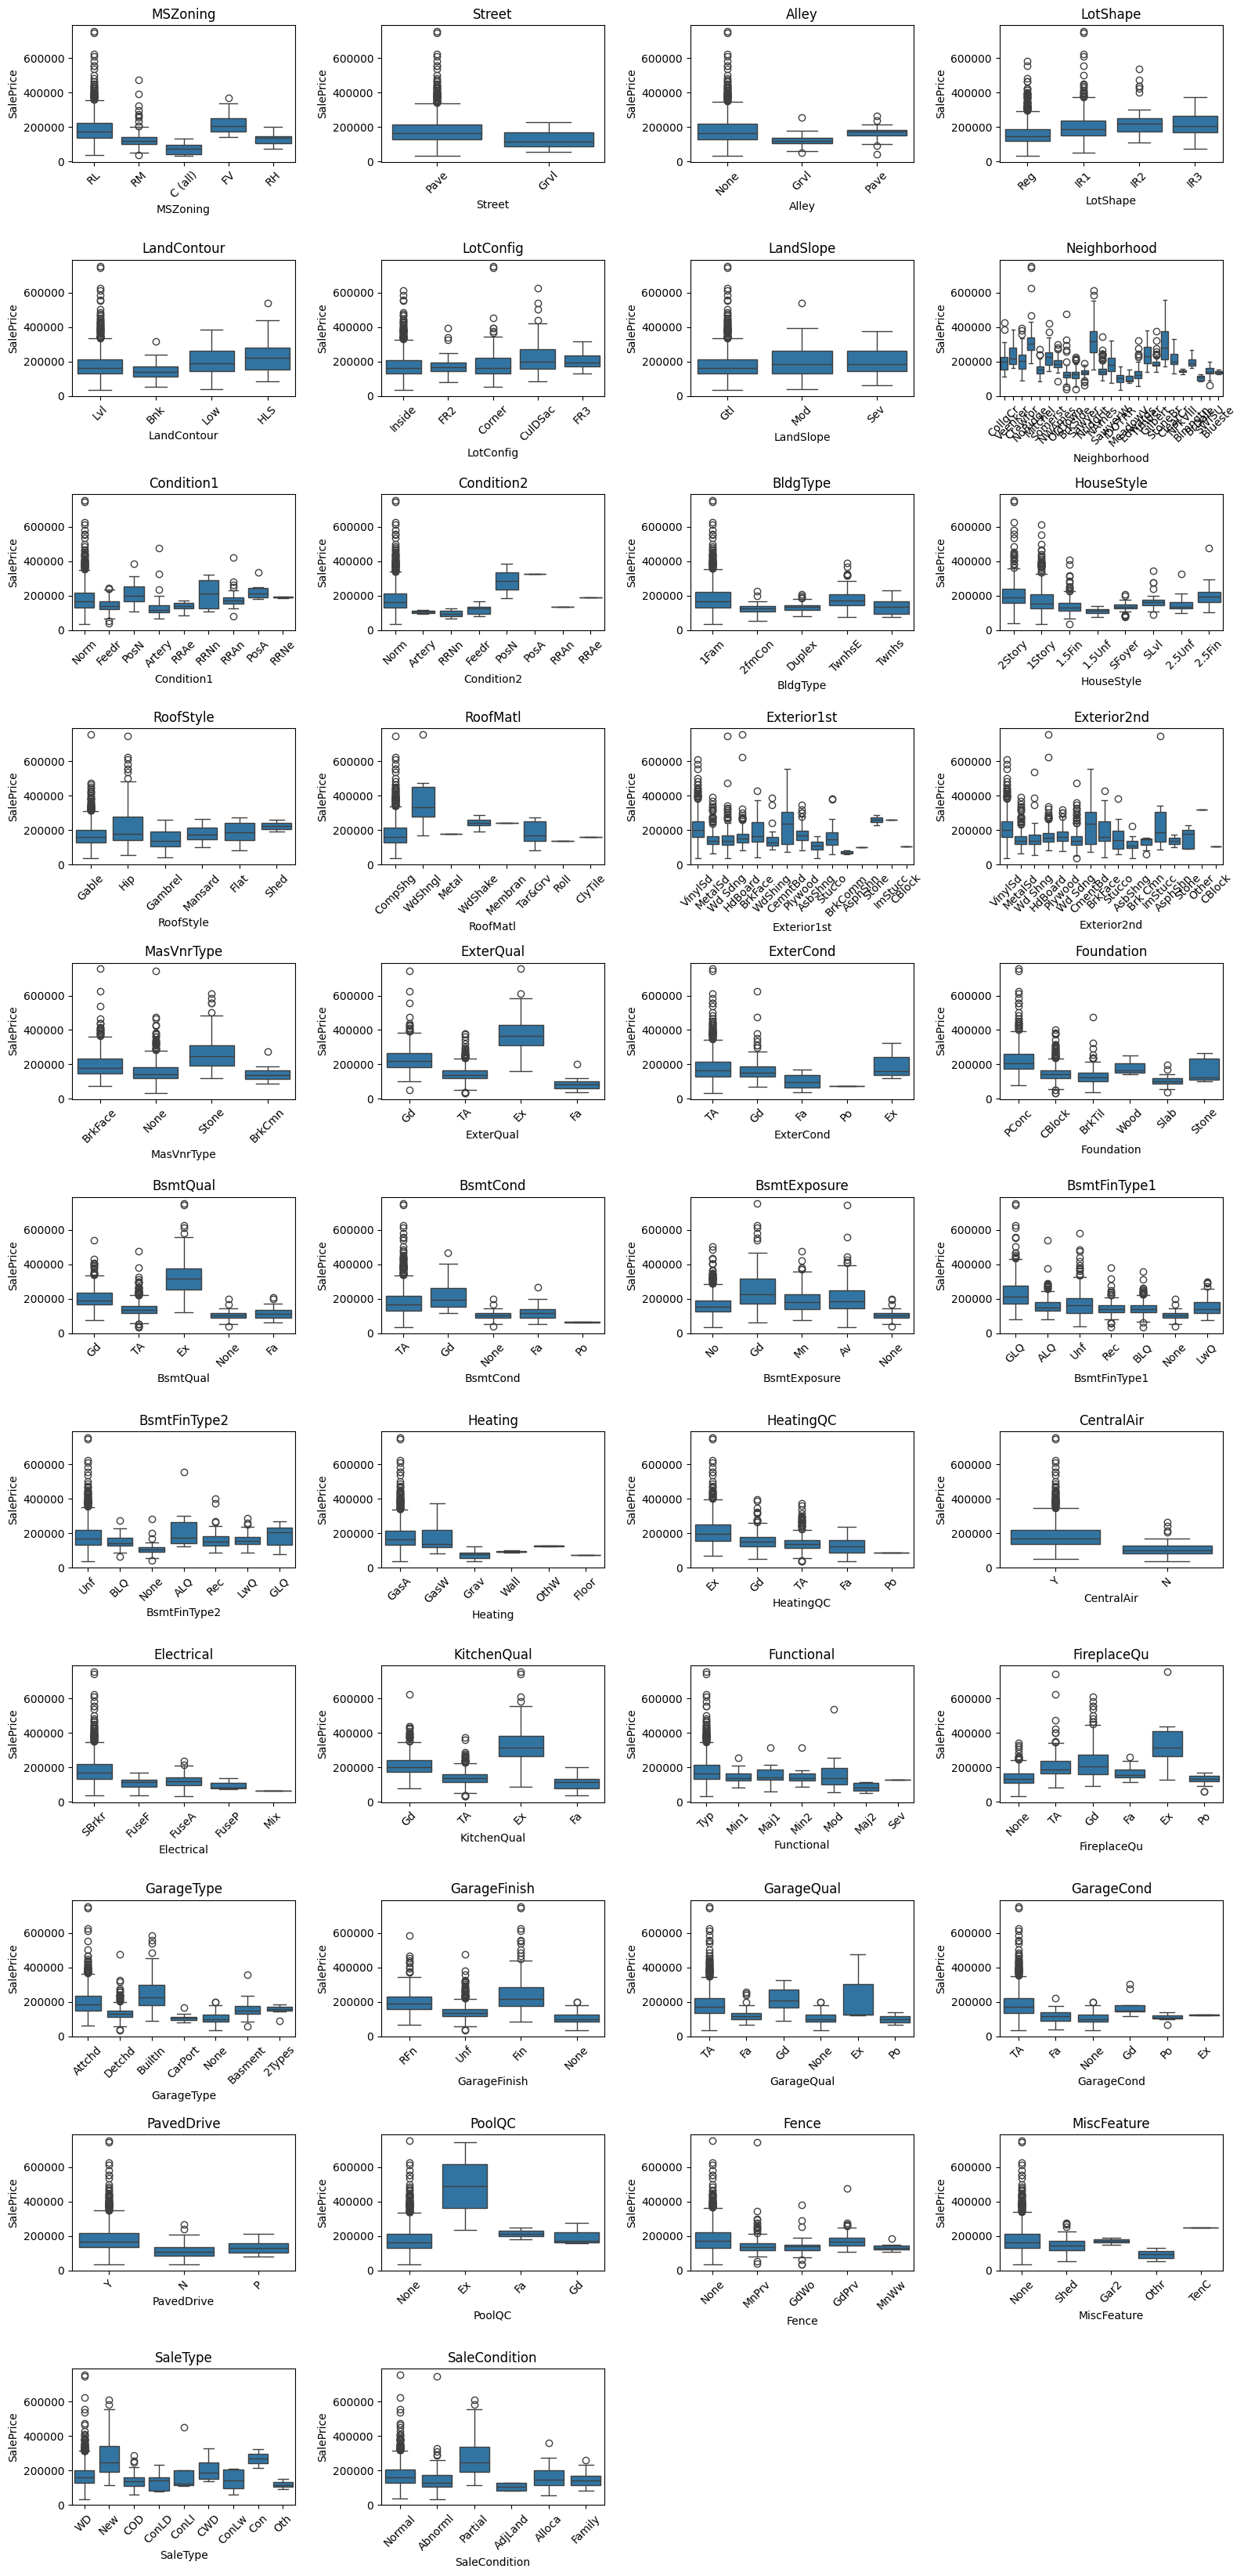

---------------------------------------


In [ ]:
# 각 수치형 특성 별로 Target인 SalesPrice와의 관계를 확인하는 메서드
def check_num_vs_saleprice(df : pd.DataFrame):

  df = df.copy()
  # df = df.drop(['SalePrice'], axis = 1)

  col_list = df.select_dtypes(exclude=['object']).columns.tolist()

  for col in col_list:
    analyze_feature_vs_saleprice(df=df, feature = col)



# 각 범주형 특성 별로 Targer인 SalesPrices와의 관계 확인 메서드
def check_obj_vs_saleprice(df : pd.DataFrame, target_col: str = 'SalePrice'):
    """
    DataFrame의 범주형 특성들과 Target 변수 간의 관계를 Boxplot으로 시각화합니다.
    여러 특성을 작은 서브플롯 격자로 배치하여 한눈에 비교할 수 있도록 합니다.

    Args:
        df (pd.DataFrame): 분석할 pandas DataFrame.
        target_col (str): Target 변수의 컬럼 이름 (기본값: 'SalePrice').
    """
    print(f"--- 범주형 특성과 {target_col} 간의 관계 분석 (Boxplot) ---")

    df = df.copy()

    # 범주형 특성 목록 가져오기 (Target 변수 제외)
    obj_cols = df.select_dtypes(include=['object']).columns.tolist()
    if target_col in obj_cols:
        obj_cols.remove(target_col)

    if not obj_cols:
        print("시각화할 범주형 특성이 없습니다.")
        return

    # 그래프 격자 크기 설정 (필요에 따라 조절 가능)
    n_cols = 4
    n_rows = (len(obj_cols) + n_cols - 1) // n_cols # 필요한 행 수 계산

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 3)) # figsize 조절

    # 서브플롯에 Boxplot 그리기
    # axs가 1차원 배열일 수 있으므로 flatten하여 사용
    axs = axs.flatten()

    for i, col in enumerate(obj_cols):
        if i < len(axs): # 서브플롯 개수 범위 내에서만 그리기
            try:
                sns.boxplot(x=df[col], y=df[target_col], ax=axs[i])
                axs[i].set_title(col)
                axs[i].set_xlabel(col)
                axs[i].set_ylabel(target_col)
                axs[i].tick_params(axis='x', rotation=45) # x축 레이블 회전
            except Exception as e:
                print(f"특성 '{col}' 시각화 중 오류 발생: {e}")
                axs[i].set_visible(False) # 오류 발생 시 해당 서브플롯 숨김

    # 남은 빈 서브플롯 숨기기
    for j in range(i + 1, len(axs)):
        axs[j].set_visible(False)

    plt.tight_layout() # 서브플롯 간 간격 자동 조절
    plt.show()

    print("-" * (len(target_col) + 30)) # 구분선 출력


# check_num_vs_saleprice(df=df_train_FE) # 수치형 특성 분석을 원하시면 주석 해제

# 범주형 특성 분석 실행
check_obj_vs_saleprice(df=df_train_FE, target_col='SalePrice')

In [ ]:
# scikit-learn에서 앙상블 트리 모델 임포트

!pip install xgboost lightgbm

#XGBoost, LightGBM, RepeatedKFold 추가
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import RepeatedKFold

from sklearn.preprocessing import StandardScaler, RobustScaler

# scikit-learn에서 선형 회귀 모델 임포트
from sklearn.linear_model import Ridge, Lasso

# 배깅 모델
from sklearn.ensemble import RandomForestClassifier # 분류용 랜덤 포레스트
from sklearn.ensemble import RandomForestRegressor # 회귀용 랜덤 포레스트

# 부스팅 모델 (scikit-learn 기본 구현)
from sklearn.ensemble import GradientBoostingClassifier # 분류용 그레디언트 부스팅
from sklearn.ensemble import GradientBoostingRegressor # 회귀용 그레디언트 부스팅
from sklearn.ensemble import AdaBoostClassifier # 분류용 에이다부스트
from sklearn.ensemble import AdaBoostRegressor # 회귀용 에이다부스트

# scikit-learn의 최신 부스팅 모델
from sklearn.ensemble import HistGradientBoostingClassifier # 분류용 히스토그레디언트 부스팅
from sklearn.ensemble import HistGradientBoostingRegressor # 회귀용 히스토그레디언트 부스팅


# 엑스트라 트리 모델
from sklearn.ensemble import ExtraTreesClassifier # 분류용 엑스트라 트리
from sklearn.ensemble import ExtraTreesRegressor # 회귀용 엑스트라 트리

# scikit-learn에서 Voting 앙상블 모델 임포트
from sklearn.ensemble import VotingClassifier # 분류 모델들의 예측 결과를 결합
from sklearn.ensemble import VotingRegressor # 회귀 모델들의 예측 결과를 결합

#K-Fold 이용한 교차 검증 으로 여러 Ensemble 모델에서 처리해보기
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error, make_scorer

from sklearn.model_selection import GridSearchCV

print("Voting 앙상블 모델 임포트 완료")

print("앙상블 트리 계열 모델 임포트 완료")

Voting 앙상블 모델 임포트 완료
앙상블 트리 계열 모델 임포트 완료


In [ ]:
# One-Hot Encoding 한 DF에 대해서 상관 계수 보기(Target인 SalesPrice에 대해서 )



# 전체 특성들과 SalePrice 간의 상관 계수 보기
correlations_with_saleprice = df_train_oneHot_FE.corr()['SalePrice'].sort_values(ascending = False)


#correlations_with_saleprice
correlations_with_saleprice_dict = correlations_with_saleprice.to_dict()

# 최종 선택된 특성들
chosen_columns = []

for col_name, corr in correlations_with_saleprice_dict.items():
  if abs(corr) > 0.3 and abs(corr) < 0.9:
    chosen_columns.append(col_name)

print(chosen_columns)
len(chosen_columns)


['TotalArea', 'OverallQual', 'TotalSF', 'GrLivArea', 'TotalSquareFootage', 'GarageCars', 'TotalBath', 'GarageArea', 'TotalBsmtSF', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt', 'YearRemodAdd', 'Foundation_PConc', 'MasVnrArea', 'HasFireplace', 'Fireplaces', 'ExterQual_Gd', 'BsmtFinType1_GLQ', 'Neighborhood_NridgHt', 'BsmtFinSF1', 'SaleType_New', 'SaleCondition_Partial', 'LotFrontage', 'FireplaceQu_Gd', 'GarageType_Attchd', 'MasVnrType_Stone', 'Neighborhood_NoRidge', 'WoodDeckSF', 'KitchenQual_Gd', '2ndFlrSF', 'OpenPorchSF', 'BsmtExposure_Gd', 'Exterior2nd_VinylSd', 'Exterior1st_VinylSd', 'HeatingQC_TA', 'Foundation_CBlock', 'GarageType_Detchd', 'MasVnrType_None', 'GarageFinish_Unf', 'BsmtQual_TA', 'FireplaceQu_None', 'KitchenQual_TA', 'ExterQual_TA']


45

In [ ]:
#K-Fold cross-validation 적용해보기
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle = True)

#RepeatedKFold 적용해보기
rkf = RepeatedKFold(n_splits=n_splits, n_repeats=5)

# Define the scoring metric (e.g., Negative Mean Squared Error, then convert to RMSE)

#mean_squared_error = 평균 제곱 오차. Regressor 모델의 성능 평가 지표 중 하나다. 모델 예측값과 실제 값의 차이를 제곱한 것들의 평균.
# 당연하게도 이 값이 낮으면 정확률이 더 높다는 거

# make_scorer = 잘 모르겠다만. scikit 에서 제공하는 교차 검증 함수들이 요구하는 scorer 양식에 맞추어 변환해준다고?
# grater_is_better 설정을 통해 최대화/최소화 문제임을 제공
rmse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

Random Forest RMSE scores: [27255.88497384 24412.14637627 28026.46513277 29977.50768568
 37726.12622492 31648.10806965 32700.10165025 27477.09987431
 24806.98228425 32433.11981526 25734.47807481 23206.1035983
 43614.95169312 28593.71162216 31984.04103637 25624.50643837
 31597.61510902 26081.86557593 33140.16615733 30446.13637825
 32326.30403887 30550.85163987 23074.71766806 29872.04511462
 32641.97572917 30297.07355256 35600.0891801  25275.04234483
 26158.26195658 29149.52560822 27491.27145257 27496.82480751
 32379.46822101 23997.92477687 33087.50366785 25159.75582277
 43028.73582821 25428.15148165 29694.45497374 25034.95022516
 34392.16563503 30315.2300106  23346.53583846 24994.70919701
 30971.82212105 40578.45511094 21443.0640255  25482.45206269
 32707.67382364 30710.79422199]
Random Forest Mean RMSE: 29583.4990
------------------------------
Gradient Boosting RMSE scores: [20504.59889373 51591.63306589 26931.22693094 29964.5101041
 21112.65082019 25250.61279551 22639.87588922 32049.

/tmp/ipython-input-1185150366.py:58: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(results.values(), labels=results.keys())


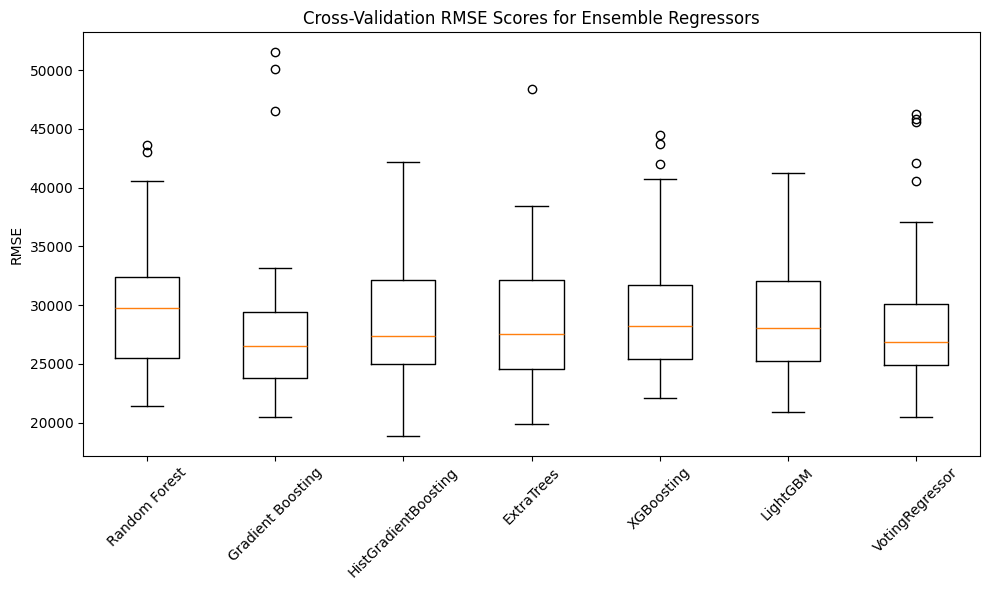

In [ ]:




#우선 Target 특성을 분리해서 정의해보자
X = df_train_oneHot_FE.drop(['SalePrice', "Id"], axis = 1)
# X = X[chosen_columns]
y = df_train_oneHot_FE['SalePrice']

# df_test_labeled_FE


rf_base = RandomForestRegressor(random_state=42)
xgb_base = xgb.XGBRegressor(random_state=42)
lgb_base = lgb.LGBMRegressor(random_state=42)



#각 모델들 정의하기
models = {
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "HistGradientBoosting" : HistGradientBoostingRegressor(random_state=42),
    "ExtraTrees" : ExtraTreesRegressor(random_state=42),
    "XGBoosting" : xgb.XGBRegressor(random_state=42),
    "LightGBM" : lgb.LGBMRegressor(random_state=42),
    "VotingRegressor" : VotingRegressor(estimators=[
        ('rf', rf_base),
        ('xgb', xgb_base),
        ('lgb', lgb_base)
    ])
}







# 각 모델들에 대해 교차 검증 학습 시작
# cross_val_score 메서드는 교차 검증 수행 메서드. cv 설정을 통해 K Fold 쓰게 함
results = {}
for name, model in models.items():
  scores = cross_val_score(model, X, y, cv = rkf, scoring = rmse_scorer, n_jobs = -1)
  rmse_scores = np.sqrt(-scores)
  results[name] = rmse_scores
  print(f"{name} RMSE scores: {rmse_scores}")
  print(f"{name} Mean RMSE: {np.mean(rmse_scores):.4f}")
  print("-" * 30)



# Print summary of results
print("\nCross-Validation Results Summary (Mean RMSE):")
for name, scores in results.items():
    print(f"{name}: {np.mean(scores):.4f}")


# 가시화

plt.figure(figsize=(10, 6))
plt.boxplot(results.values(), labels=results.keys())
plt.title('Cross-Validation RMSE Scores for Ensemble Regressors')
plt.ylabel('RMSE')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
# Bayesian Optimization을 위한 search space 정의

#우선 Target 특성을 분리해서 정의해보자
X = df_train_oneHot_FE.drop(['SalePrice', "Id"], axis = 1)
# X = X[chosen_columns]
y = df_train_oneHot_FE['SalePrice']


# GradientBoostingRegressor의 주요 하이퍼파라미터를 정의합니다.
space = [
    Integer(50, 500, name='n_estimators'), # 부스팅 단계 수
    Real(0.01, 0.2, prior='log-uniform', name='learning_rate'), # 학습률
    Integer(3, 10, name='max_depth'), # 각 회귀 트리의 최대 깊이
    Integer(50, 200, name='min_samples_leaf'), # 리프 노드가 되기 위한 최소 샘플 수
    Real(0.1, 1.0, name='max_features') # 각 분할에서 고려할 특성의 최대 수
]

# 목적 함수 정의 (최소화할 대상 - RMSE)
# cross_val_score를 사용하여 K-Fold 교차 검증을 수행하고 평균 RMSE를 반환합니다.
@use_named_args(space)
def objective(**params):
    model = GradientBoostingRegressor(random_state=42, **params)
    # RMSE를 최소화하는 것이 목표이므로, negative mean squared error를 사용하고 -1을 곱합니다.
    scores = cross_val_score(model, X, y, cv=kf, scoring=rmse_scorer, n_jobs=-1)
    rmse_scores = np.sqrt(-scores)
    mean_rmse = np.mean(rmse_scores)
    # gp_minimize는 최소화 함수를 기대하므로, 평균 RMSE를 그대로 반환합니다.
    return mean_rmse

# Bayesian Optimization 실행
print("Bayesian Optimization 시작...")
res_gp = gp_minimize(objective, space, n_calls=50, random_state=42, n_jobs=-1) # n_calls는 시도할 하이퍼파라미터 조합의 수

print("\nBayesian Optimization 완료.")

# 최적의 하이퍼파라미터와 최적의 점수 (RMSE) 출력
print(f"\nBest RMSE (minimized): {res_gp.fun:.4f}")
print("Best hyperparameters:")
best_params = dict(zip([p.name for p in space], res_gp.x))
print(best_params)

# 최적의 하이퍼파라미터로 모델 재학습
best_gb_model = GradientBoostingRegressor(random_state=42, **best_params)
best_gb_model.fit(X, y)

print("\n최적 하이퍼파라미터로 GradientBoostingRegressor 모델 재학습 완료.")

Bayesian Optimization 시작...

Bayesian Optimization 완료.

Best RMSE (minimized): 27043.2924
Best hyperparameters:
{'n_estimators': np.int64(500), 'learning_rate': 0.04501642379554941, 'max_depth': np.int64(10), 'min_samples_leaf': np.int64(50), 'max_features': 0.1}

최적 하이퍼파라미터로 GradientBoostingRegressor 모델 재학습 완료.


Bayesian Optimization을 통해 찾은 최적의 하이퍼파라미터로 Gradient Boosting Regressor 모델을 학습했습니다. 이제 이 모델을 사용하여 예측을 수행하고 결과를 제출 파일로 생성할 수 있습니다.

In [ ]:
# Test 데이터 준비 (이전 셀에서 이미 정의됨)
test_ids = df_test_oneHot_FE["Id"]
X_test = df_test_oneHot_FE.drop(["Id"], axis = 1)
# X_test = X_test[X.columns] # 학습 데이터와 동일한 특성 순서 및 개수 유지

# 최적 모델로 예측 수행
predictions = best_gb_model.predict(X_test)

# 제출 파일 생성
submission_df = pd.DataFrame({
    "Id" : test_ids,
    "SalePrice" : predictions
})

submission_df.to_csv("submission_bayesian_opt.csv", index = False)

print("submission_bayesian_opt.csv 파일 생성 완료.")

# Google Colab 에서 파일 다운로드
from google.colab import files
files.download('submission_bayesian_opt.csv')

submission_bayesian_opt.csv 파일 생성 완료.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

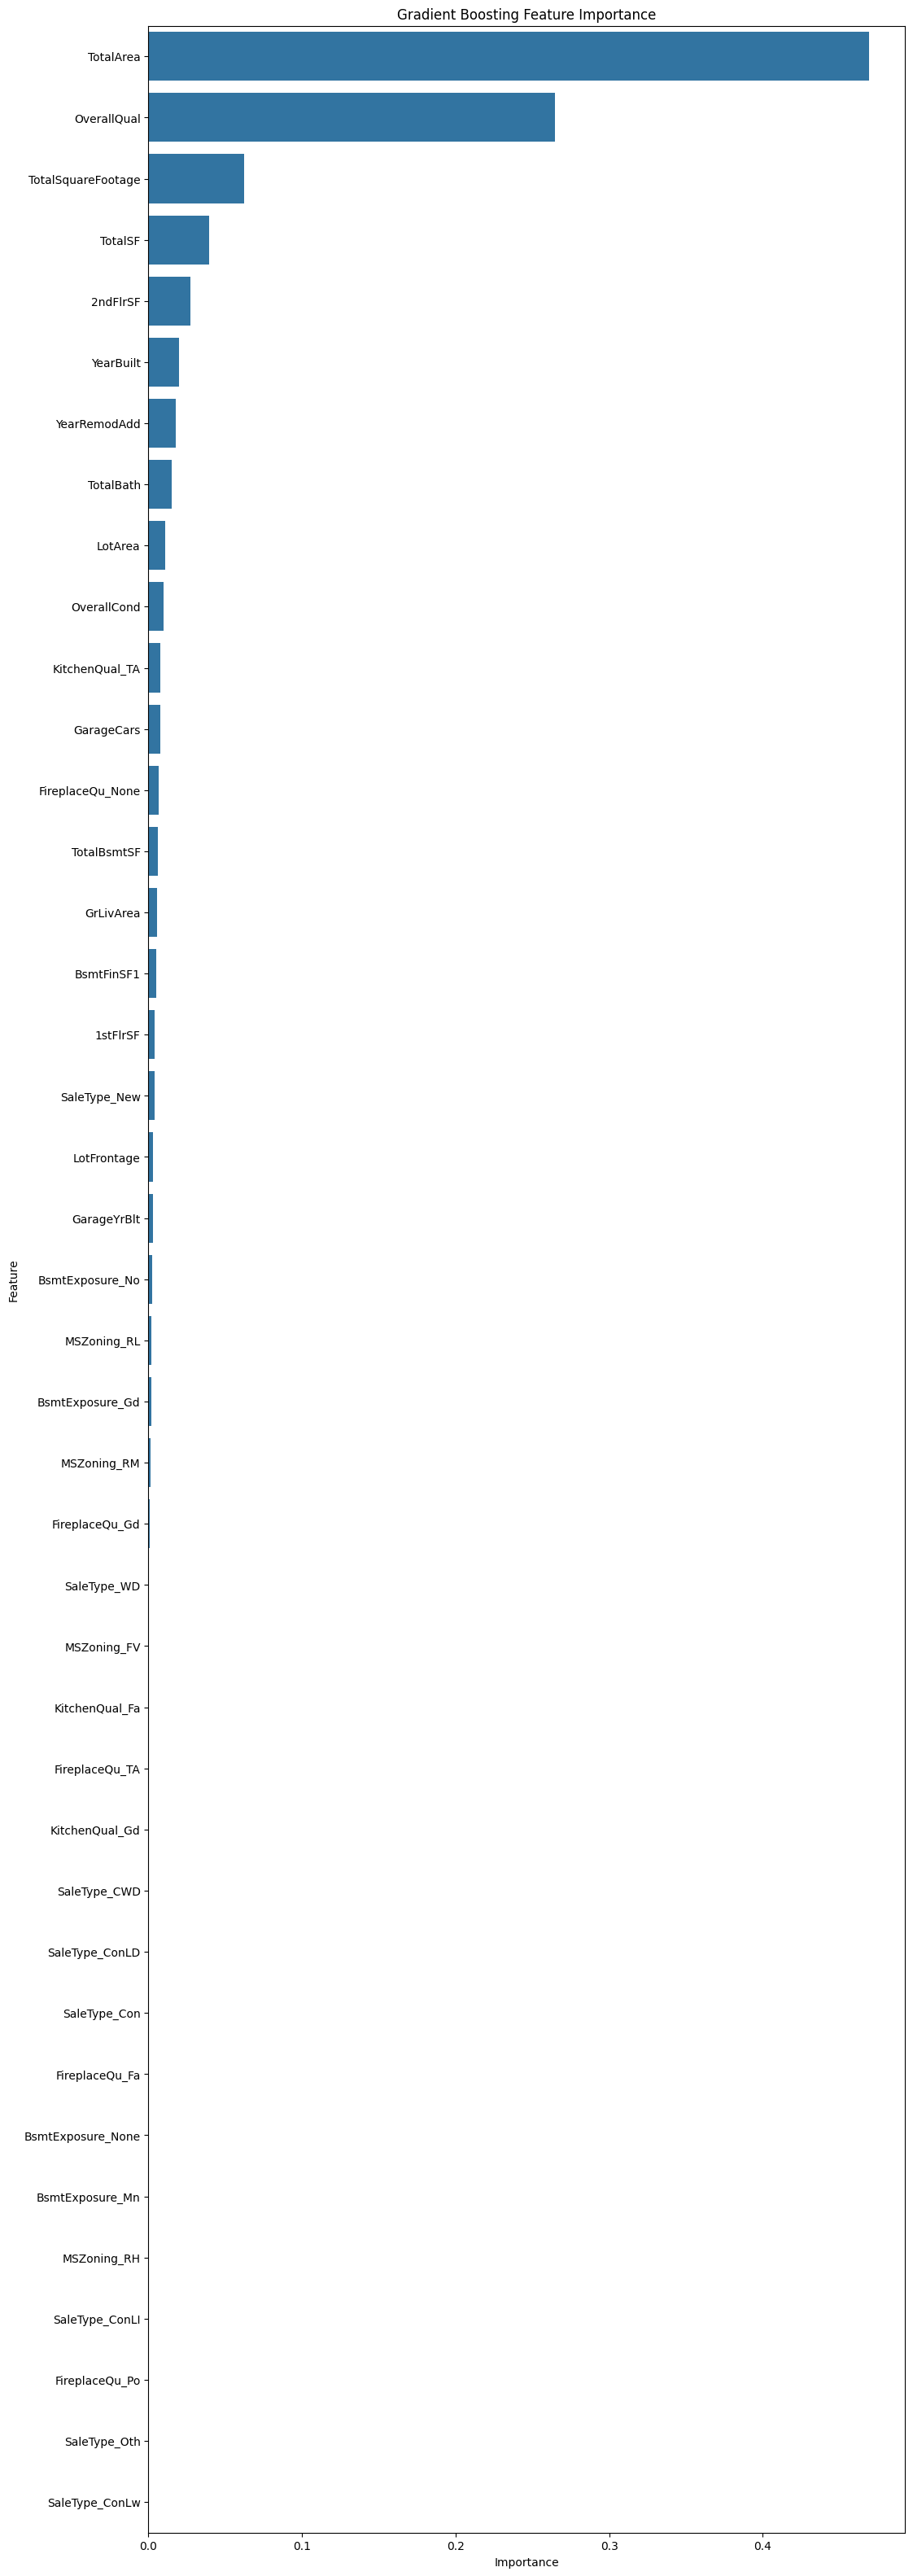

In [ ]:
# 모델 학습 후 특성의 중요도를 직접 확인해보자.

model = GradientBoostingRegressor(random_state=42)
model.fit(X, y)

# 중요도 및 특성 이름들 가져오기
feature_importances = model.feature_importances_
feature_names = X.columns


# 특성 중요도를 DataFrame으로 만들어보기
importance_df = pd.DataFrame({"Feature" : feature_names, "Importance" : feature_importances})
importance_df_sorted = importance_df.sort_values('Importance', ascending = False)



#시각화
plt.figure(figsize = (12, 40))
sns.barplot(x = 'Importance', y = 'Feature', data = importance_df_sorted)
plt.title('Gradient Boosting Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [ ]:
# XGBoost Regressor의 Bayesian Optimization을 위한 search space 정의
# Target 특성은 이미 위에서 정의된 X, y 사용

# XGBoost Regressor의 주요 하이퍼파라미터를 정의합니다.
# XGBoost는 objective='reg:squarederror' (회귀)를 기본으로 사용합니다.
space_xgb = [
    Integer(50, 1000, name='n_estimators'), # 부스팅 단계 수
    Real(0.01, 0.3, prior='log-uniform', name='learning_rate'), # 학습률
    Integer(3, 15, name='max_depth'), # 각 트리의 최대 깊이
    Real(0.5, 1.0, name='subsample'), # 각 트리를 학습할 때 사용할 샘플의 비율
    Real(0.5, 1.0, name='colsample_bytree'), # 각 트리를 학습할 때 사용할 특성의 비율
    Real(0.0, 0.5, name='reg_alpha'), # L1 정규화 항
    Real(0.0, 0.5, name='reg_lambda') # L2 정규화 항
]

# 목적 함수 정의 (최소화할 대상 - RMSE)
# cross_val_score를 사용하여 Repeated K-Fold 교차 검증을 수행하고 평균 RMSE를 반환합니다.
@use_named_args(space_xgb)
def objective_xgb(**params):
    model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, **params)
    # RMSE를 최소화하는 것이 목표이므로, negative mean squared error를 사용하고 -1을 곱합니다.
    scores = cross_val_score(model, X, y, cv=rkf, scoring=rmse_scorer, n_jobs=-1) # rkf 사용
    rmse_scores = np.sqrt(-scores)
    mean_rmse = np.mean(rmse_scores)
    # gp_minimize는 최소화 함수를 기대하므로, 평균 RMSE를 그대로 반환합니다.
    return mean_rmse

# Bayesian Optimization 실행
print("XGBoost Bayesian Optimization 시작...")
res_gp_xgb = gp_minimize(objective_xgb, space_xgb, n_calls=50, random_state=42, n_jobs=-1) # n_calls는 시도할 하이퍼파라미터 조합의 수

print("\nXGBoost Bayesian Optimization 완료.")

# 최적의 하이퍼파라미터와 최적의 점수 (RMSE) 출력
print(f"\nBest RMSE (minimized) for XGBoost: {res_gp_xgb.fun:.4f}")
print("Best hyperparameters for XGBoost:")
best_params_xgb = dict(zip([p.name for p in space_xgb], res_gp_xgb.x))
print(best_params_xgb)

# 최적의 하이퍼파라미터로 XGBoost 모델 재학습 (선택 사항)
best_xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, **best_params_xgb)
best_xgb_model.fit(X, y)

print("\n최적 하이퍼파라미터로 XGBoostRegressor 모델 재학습 완료.")

XGBoost Bayesian Optimization 시작...


KeyboardInterrupt: 

In [ ]:
# LightGBM Regressor의 Bayesian Optimization을 위한 search space 정의
# Target 특성은 이미 위에서 정의된 X, y 사용

# LightGBM Regressor의 주요 하이퍼파라미터를 정의합니다.
# LightGBM은 objective='regression' (회귀)를 기본으로 사용합니다.
space_lgbm = [
    Integer(50, 1000, name='n_estimators'), # 부스팅 단계 수
    Real(0.01, 0.3, prior='log-uniform', name='learning_rate'), # 학습률
    Integer(20, 200, name='num_leaves'), # 트리의 최대 리프 노드 수 (max_depth보다 우선)
    Integer(5, 50, name='min_child_samples'), # 리프 노드에 필요한 최소 데이터 수
    Real(0.5, 1.0, name='subsample'), # 데이터를 샘플링하는 비율 (bagging_fraction)
    Real(0.5, 1.0, name='colsample_bytree'), # 각 트리를 학습할 때 사용할 특성의 비율 (feature_fraction)
    Real(0.0, 0.5, name='reg_alpha'), # L1 정규화 항
    Real(0.0, 0.5, name='reg_lambda') # L2 정규화 항
]

# 목적 함수 정의 (최소화할 대상 - RMSE)
# cross_val_score를 사용하여 Repeated K-Fold 교차 검증을 수행하고 평균 RMSE를 반환합니다.
@use_named_args(space_lgbm)
def objective_lgbm(**params):
    # LightGBM 파라미터 이름 매핑
    lgbm_params = {
        'n_estimators': params['n_estimators'],
        'learning_rate': params['learning_rate'],
        'num_leaves': params['num_leaves'],
        'min_child_samples': params['min_child_samples'],
        'subsample': params['subsample'], # LightGBM에서는 bagging_fraction
        'colsample_bytree': params['colsample_bytree'], # LightGBM에서는 feature_fraction
        'reg_alpha': params['reg_alpha'], # LightGBM에서는 lambda_l1
        'reg_lambda': params['reg_lambda'] # LightGBM에서는 lambda_l2
    }
    model = lgb.LGBMRegressor(objective='regression', random_state=42, **lgbm_params)
    # RMSE를 최소화하는 것이 목표이므로, negative mean squared error를 사용하고 -1을 곱합니다.
    scores = cross_val_score(model, X, y, cv=rkf, scoring=rmse_scorer, n_jobs=-1) # rkf 사용
    rmse_scores = np.sqrt(-scores)
    mean_rmse = np.mean(rmse_scores)
    # gp_minimize는 최소화 함수를 기대하므로, 평균 RMSE를 그대로 반환합니다.
    return mean_rmse

# Bayesian Optimization 실행
print("LightGBM Bayesian Optimization 시작...")
res_gp_lgbm = gp_minimize(objective_lgbm, space_lgbm, n_calls=30, random_state=42, n_jobs=-1) # n_calls는 시도할 하이퍼파라미터 조합의 수

print("\nLightGBM Bayesian Optimization 완료.")

# 최적의 하이퍼파라미터와 최적의 점수 (RMSE) 출력
print(f"\nBest RMSE (minimized) for LightGBM: {res_gp_lgbm.fun:.4f}")
print("Best hyperparameters for LightGBM:")
best_params_lgbm = dict(zip([p.name for p in space_lgbm], res_gp_lgbm.x))
print(best_params_lgbm)

# 최적의 하이퍼파라미터로 LightGBM 모델 재학습 (선택 사항)
# LightGBM 파라미터 이름에 맞게 변환 후 전달
best_lgbm_params_tuned = {
    'n_estimators': best_params_lgbm['n_estimators'],
    'learning_rate': best_params_lgbm['learning_rate'],
    'num_leaves': best_params_lgbm['num_leaves'],
    'min_child_samples': best_params_lgbm['min_child_samples'],
    'subsample': best_params_lgbm['subsample'], # LightGBM에서는 bagging_fraction
    'colsample_bytree': best_params_lgbm['colsample_bytree'], # LightGBM에서는 feature_fraction
    'reg_alpha': best_params_lgbm['reg_alpha'], # LightGBM에서는 lambda_l1
    'reg_lambda': best_params_lgbm['reg_lambda'] # LightGBM에서는 lambda_l2
}

best_lgbm_model = lgb.LGBMRegressor(objective='regression', random_state=42, **best_lgbm_params_tuned)
best_lgbm_model.fit(X, y)

print("\n최적 하이퍼파라미터로 LightGBMRegressor 모델 재학습 완료.")

In [ ]:
# 일단 무작정 제출해보자!

# One-Hot Encoding, 모든 특성 살려놓은 상태, GradientBoosting 모델

#Test data Id 분리
test_ids = df_test_oneHot_FE["Id"]

# Test 데이터 준비
X_test = df_test_oneHot_FE.drop(["Id"], axis = 1)
X_test = X_test[X.columns]

# GradientBoosting 모델로 Predict
predictions = gsGBC.predict(X_test)


submission_df = pd.DataFrame({
    "Id" : test_ids,
    "SalePrice" : predictions
})

submission_df.to_csv("submission.csv", index = False)

# Google Colab 에서 파일 다운로드
from google.colab import files
files.download('submission.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>